In [1]:
from ColorExtractor import post
import re
import typer
res = [int(s) for s in re.findall(
    r'\d+', "8756_8768_12124_12137_z15_t110400")]
# print(res)
zoom = res[4]
# print(res[0], res[2])
# print(res[1], res[3])
NW_lat, NW_lng = post.num2deg(res[0], res[2]-1, zoom)
SE_lat, SE_lng = post.num2deg(res[1]+1, res[3], zoom)
# print(NW_lat, NW_lng)
# print(SE_lat, SE_lng)

# Estabilish the size of the image
X = SE_lng - NW_lng 
Y = SE_lat - NW_lat

In [16]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
# green, yellow, red, dark red
bg_color = [[148, 200, 97], [225, 131, 49], [211, 45, 31],  [146, 36, 29]]
# color similarity threshold
threshold = 6000


# Generate Conv filter by the lng_seq and lat_seq

def DDA(x1, y1, x2, y2, point_list):
    dx = x2 - x1
    dy = y2 - y1
    steps = max(abs(dx), abs(dy))
    x_inc = dx / steps
    y_inc = dy / steps
    x = x1
    y = y1
    for i in range(steps):
        point_list.append((int(x), int(y)))
        x += x_inc
        y += y_inc

def gen_Filter(lng_seq, lat_seq, idx, h, w):
    # cv.line(logo, (lng, 0), (lng, h), (0, 255, 255), thickness=2)
    # cv.line(logo, (0, lat), (w, lat), (255, 0, 0), thickness=2)
        
    lng = lng_seq[0]
    lat = lat_seq[0]
    
    lng = int(h*lng)
    lat = int(w*lat)
    
    rest_point_delta = [(0, 0)]
    max_lng_delta = 0
    max_lat_delta = 0
    for i in range(1, len(lng_seq)):
        lng_ = int(h*lng_seq[i])
        lat_ = int(w*lat_seq[i])
        max_lat_delta = max(max_lat_delta, abs(lat_-lat))
        max_lng_delta = max(max_lng_delta, abs(lng_-lng))
        rest_point_delta.append((lat_ - lat, lng_ - lng))
    rest_point_delta = list(set(rest_point_delta))
    max_delta = max(max_lat_delta, max_lng_delta)
    # if max_delta % 2 != 0:
    #     max_delta += 1
    width = max(max_delta + 1, 12)
    kernel_size = (width, width)
    kernel = np.zeros(kernel_size, np.uint8)
    if max_lat_delta > max_lng_delta:
        rest_point_delta.sort(key=lambda x: x[0])
    else:
        rest_point_delta.sort(key=lambda x: x[1])
    # DDA interpolation
    interpolated_point = []
    for i in range(len(rest_point_delta) - 1):
        DDA(rest_point_delta[i][0], rest_point_delta[i][1],
            rest_point_delta[i+1][0], rest_point_delta[i+1][1], interpolated_point)
    interpolated_point.append(rest_point_delta[-1])

    
    for point in interpolated_point:
        if max_lat_delta > max_lng_delta:
            kernel[point[0]][point[1]+max_lat_delta//2] = 1

            # # Extend the range
            # delta = [(1, 0), (-1, 0), (0, 1), (0, -1)]
            # for d in delta:
            #     if 0 <= point[0]+d[0] < max_delta+1 and 0 <= point[1]+d[1]+max_lat_delta//2 < max_delta+1:
            #         kernel[point[0]+d[0]][point[1]+max_lat_delta//2+d[1]] = max(kernel[point[0]+d[0]][point[1]+max_lat_delta//2+d[1]], 1)
            
            # delta = [(2, 0), (-2, 0), (0, 2), (0, -2)]
            # for d in delta:
            #     if 0 <= point[0]+d[0] < max_delta+1 and 0 <= point[1]+d[1]+max_lat_delta//2 < max_delta+1:
            #         kernel[point[0]+d[0]][point[1]+max_lat_delta//2+d[1]] = max(kernel[point[0]+d[0]][point[1]+max_lat_delta//2+d[1]], 1)
            
        else:
            
            kernel[point[0]+max_lng_delta//2][point[1]] = 1  

            # # Extend the range
            # delta = [(1, 0), (-1, 0), (0, 1), (0, -1)]
            # for d in delta:
            #     if 0 <= point[0]+d[0]+max_lng_delta//2 < max_delta+1 and 0 <= point[1]+d[1] < max_delta+1:
            #         kernel[point[0]+max_lng_delta//2+d[0]][point[1]+d[1]] = max(kernel[point[0]+max_lng_delta//2+d[0]][point[1]+d[1]], 1)
            
            # delta = [(2, 0), (-2, 0), (0, 2), (0, -2)]
            # for d in delta:
            #     if 0 <= point[0]+d[0]+max_lng_delta//2 < max_delta+1 and 0 <= point[1]+d[1] < max_delta+1:
            #         kernel[point[0]+max_lng_delta//2+d[0]][point[1]+d[1]] = max(kernel[point[0]+max_lng_delta//2+d[0]][point[1]+d[1]], 1)
    
    return kernel


def image_process(lng: float, lat: float, idx, output=None):
    # cv.line(logo, (lng, 0), (lng, h), (0, 255, 255), thickness=2)
    # cv.line(logo, (0, lat), (w, lat), (255, 0, 0), thickness=2)
    try:
        logo = cv.imread('./output/8756_8768_12124_12137_z15_t' +
                         str(idx*600)+'.png')
        logo = cv.cvtColor(logo, cv.COLOR_BGR2RGB)
        h, w = logo.shape[0:2]
        x = 12
        plt.imshow(logo)
        print(h*lng-x, h*lng+x, w*lat-x, w*lat+x)
        lng = int(h*lng)
        lat = int(w*lat)
        cropped = logo[max(0, lat-x): min(w, lat+x),
                       max(0, lng-x): min(h, lng+x)]  # [y0:y1, x0:x1]
        plt.imshow(cropped)
        # cv.imwrite("./tmp/" + output + ".png",
        #            cv.cvtColor(logo, cv.COLOR_RGB2BGR))
        # cv.line(logo, (0, 0), (w, h), (0, 255, 0), thickness=2)
        # cv.line(logo, (0, h), (w, 0), (0, 255, 0), thickness=2)

        t = [0, 0, 0, 0]
        for i in range(cropped.shape[0]):
            for j in range(cropped.shape[1]):
                if(cropped[i][j][0] == 255 and cropped[i][j][1] == 255 and cropped[i][j][2] == 255):
                    continue
                for k in range(len(bg_color)):
                    if post.calc_diff(cropped[i][j], k):
                        t[k] += 1
        return t.index(max(t))
    except:
        return -1

In [7]:
# import torch.nn.functional as F
def image_process_position_seq(lng_seq, lat_seq, idx, output=None):
    # cv.line(logo, (lng, 0), (lng, h), (0, 255, 255), thickness=2)
    # cv.line(logo, (0, lat), (w, lat), (255, 0, 0), thickness=2)
    try:
        logo = cv.imread('./output/8756_8768_12124_12137_z15_t' +
                         str(idx*600)+'.png')
        logo = cv.cvtColor(logo, cv.COLOR_BGR2RGB)
        h, w = logo.shape[0:2]
        
        lng = lng_seq[0]
        lat = lat_seq[0]
    
        lng = int(h*lng)
        lat = int(w*lat)
        
        print("First point: ", lng, lat)
        rest_point_delta = [(0, 0)]
        max_delta = 0
        for i in range(1, len(lng_seq)):
            lng_ = int(h*lng_seq[i])
            lat_ = int(w*lat_seq[i])
            max_delta = max(max_delta, max(abs(lng_-lng), abs(lat_-lat)))
            rest_point_delta.append((lat_ - lat, lng_ - lng))
        rest_point_delta = set(rest_point_delta)
        print("point delta: ", rest_point_delta)
        print("Max delta: ", max_delta)
        
        img_half_width = max(max_delta + 1, 12)
        point_on_map = np.zeros((2*img_half_width, 2*img_half_width))
        for point in rest_point_delta:
            point_on_map[point[0]+img_half_width][point[1]+img_half_width] = 1
        cropped = logo[max(0, lat-img_half_width): min(w, lat+img_half_width),
                       max(0, lng-img_half_width): min(h, lng+img_half_width)]  # [y0:y1, x0:x1]
        
        # Generate filter kernel
        kernel = gen_Filter(lng_seq, lat_seq, idx, h, w)
        # Extract road
        cropped_road = np.zeros((cropped.shape[0], cropped.shape[1]))
        for i in range(cropped.shape[0]):
            for j in range(cropped.shape[1]):
                # Skip white pixel
                if(cropped[i][j][0] == 255 and cropped[i][j][1] == 255 and cropped[i][j][2] == 255):
                    continue
                for k in range(len(bg_color)):
                    if post.calc_diff(cropped[i][j], k):
                        cropped_road[i][j] = 1
                        break
        
        # Apply filter
        
        print("Kernel size: ", kernel.shape)
        print("Image size: ", cropped_road.shape)
        # output = convolve2D(cropped_road, kernel, padding=paddle_size)

        output = cv.filter2D(cropped_road, 1, kernel)
        # output = F.conv2d(cropped_road, kernel)
        threshold = int(kernel.sum() * 0.5)
        output[output < threshold] = 0
        output[output >= threshold] = 1
        
        # Mix the point on map with the cropped image
        fig = plt.figure(figsize=[6,6])
        ax = fig.add_subplot(121)
        ax.imshow(cropped)
        ax.imshow(output, alpha=0.5)
        # subtitle
        ax.set_title("Interest road")

        ax = fig.add_subplot(122)
        ax.imshow(cropped)
        ax.imshow(point_on_map, alpha=0.5)
        ax.set_title("Actual trajectory")
        plt.show()
        
        t = [0, 0, 0, 0]
        for i in range(cropped.shape[0]):
            for j in range(cropped.shape[1]):
                if(cropped[i][j][0] == 255 and cropped[i][j][1] == 255 and cropped[i][j][2] == 255):
                    continue
                for k in range(len(bg_color)):
                    if post.calc_diff(cropped[i][j], k):
                        t[k] += 1
        return t.index(max(t))
    except:
        return -1

In [4]:
import pandas as pd
filename = 'VED_181003_week'
_input = pd.read_csv('./ved_data_enrichment/data/ved-final/'+filename+'.csv',
                             dtype={"Latitude[deg]": float, 'Longitude[deg]': float,
                                    'Vehicle Speed[km/h]': float, 'Speed Limit[km/h]': 'string'},
                             nrows=1000)
_input.head()

,DayNum,VehId,Trip,Timestamp(ms),Latitude[deg],Longitude[deg],Vehicle Speed[km/h],MAF[g/sec],Engine RPM[RPM],Absolute Load[%],...,Energy_Consumption,Matchted Latitude[deg],Matched Longitude[deg],Match Type,Class of Speed Limit,Speed Limit[km/h],Speed Limit with Direction[km/h],Intersection,Focus Points,Bus Stops
0,337.031765,135.0,2253.0,0.0,42.272892,-83.74937,35.0,3.67,1062.0,14.117647,...,0.000948,42.272891,-83.749365,0,0.0,40,40.0,NaN,NaN,crossing
1,337.031765,135.0,2253.0,500.0,42.272892,-83.74937,35.0,9.46,1320.0,14.117647,...,0.002443,42.272891,-83.749365,1,0.0,40,40.0,NaN,NaN,crossing
2,337.031765,135.0,2253.0,1100.0,42.272892,-83.74937,34.0,9.46,1320.0,14.117647,...,0.002373,42.272891,-83.749365,1,0.0,40,40.0,NaN,NaN,crossing
3,337.031765,135.0,2253.0,2600.0,42.272892,-83.74937,33.0,11.48,1500.0,14.117647,...,0.002795,42.272891,-83.749365,1,0.0,40,40.0,NaN,NaN,crossing
4,337.031765,135.0,2253.0,3100.0,42.272633,-83.74945,33.0,11.48,1500.0,14.117647,...,0.002795,42.272633,-83.749450,0,-1.0,40-48,40.0,NaN,NaN,NaN


First point:  1248 1729
point delta:  {(-13, 1), (-22, 2), (-30, 5), (0, 0)}
Max delta:  30
Kernel size:  (31, 31)
Image size:  (62, 62)


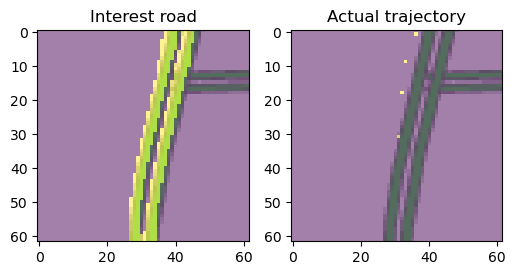

In [20]:

_input = _input[['DayNum', 'Latitude[deg]', 'Longitude[deg]', 'Vehicle Speed[km/h]', 'Speed Limit[km/h]']]
_input['Speed Limit[km/h]'] = pd.to_numeric(_input['Speed Limit[km/h]'], errors='coerce')
_input = _input.assign(Color_code='-1')
_input['Index'] = _input['DayNum'].apply(post.timeCalc)

for index, row in _input.iterrows():
# if(chunk['Vehicle Speed[km/h]'].at[index] / chunk['Speed Limit[km/h]'].at[index] >= 0.9):
#     continue  
    index = 59
    if index > 18:
        longitude_seq = []
        latitude_seq = []
        for i in range(12):
            # Change every 6 items
            new_index = index
            longitude_seq.append((_input['Longitude[deg]'].at[index - i] - NW_lng)/X)
            latitude_seq.append((_input['Latitude[deg]'].at[index - i] - NW_lat)/Y)
        _input['Color_code'].at[index] = image_process_position_seq(longitude_seq, latitude_seq, _input['Index'].at[index])
        break
    else:
        _input['Color_code'].at[index] = image_process(
            (_input['Longitude[deg]'].at[index] - NW_lng)/X,
            (_input['Latitude[deg]'].at[index] -NW_lat)/Y,
            _input['Index'].at[index])
        break